<a href="https://colab.research.google.com/github/aniparnagian/iphs290_cultural_analytics_sentiment_analysis/blob/main/Anne_of_Green_Gables_Sentiment_Analysis_(IPHS_290%2C_12_5_2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Code By Jon Chun on 24 Oct 2021, Modified by Ani Parnagian on IPHS 290, for IPHS 290: Cultural Analytics 

# **Requirements**

* Must use **Chrome** browser (esp not Safari)
* Use only **plain text** files (no *.rtf, *.doc, etc)

# **Setup and Configuration**

In [ ]:
!nvidia-smi

Mon Dec  5 20:35:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 17.3 MB/s 
     |████████████████████████████████| 182 kB 65.4 MB/s 
     |████████████████████████████████| 7.6 MB 40.4 MB/s 


In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 9.7 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=cc87053e647a4effd781ecf13ed9d1a929cee1f43e37db0f20e6d7d456423dff
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [ ]:
!pip install unidecode  # clean-text dependency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 27.2 MB/s 


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 52.5 MB/s 
     |████████████████████████████████| 287 kB 42.2 MB/s 


In [ ]:
!pip install python-slugify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from slugify import slugify

In [ ]:
# Python Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from cleantext import clean
import contractions
from slugify import slugify

from scipy.signal import find_peaks

from google.colab import files



In [ ]:
# Setup matplotlib

# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Globals

In [ ]:
# Global Vars

novel_filename_str = ''
novel_title_str = ''
novel_raw_str = ''
novel_clean_str = ''

novel_lines_ls = []
novel_sentences_ls = []
novel_paragraphs_ls = []

# Main (Modin) DataFrame for Novel Sentiments
sentiment_df = pd.DataFrame

TEXT_ENCODING = 'utf-8'

In [ ]:
def verify_novel(anovel_raw_str, anovel_title_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Title: {anovel_title_str}')
  print(f'  Char Len: {len(anovel_raw_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {anovel_raw_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {anovel_raw_str[-index_ends:]}\n\n')

In [ ]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [ ]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False) 
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

In [ ]:
def expand_contractions(input_str):
  '''
  INPUT: long string
  OUTPUT: long string with expanded contractions
  '''

  output_str = contractions.fix(input_str)

  return output_str

"""
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]
"""

'\n# novel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_ls]\nnovel_clean_ls = [contractions.fix(x) for x in novel_ls]\nnovel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_clean_ls]\nnovel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]\n# novel_clean_ls = [re.sub(r"^["\']", "", x) for x in novel_clean_ls]  # re.sub("["\']", "", s)\n# novel_clean_ls = [re.sub(r"["\']$", "", x) for x in novel_clean_ls]\nnovel_clean_ls = [x.encode(\'ascii\',errors=\'ignore\').decode() for x in novel_clean_ls]\n# novel_bin = novel_clean_str.encode(\'ascii\',errors=\'ignore\')\n# novel_clean_str = novel_bin.decode()\n\n[f\'[{x}]\' for x in novel_clean_ls]\n'

# **Get the Novel Text**

## OPTION (a): Upload Raw Textfile

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)

Saving Anne of Green Gables .txt to Anne of Green Gables .txt
User uploaded file "Anne of Green Gables .txt" with length 586654 bytes
CPU times: user 88 ms, sys: 15.1 ms, total: 103 ms
Wall time: 11.6 s


In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Anne of Green Gables By Lucy Maud Montgomery " #@param {type:"string"}

# Remove illegal filename punctuation
Novel_Title = Novel_Title.replace("'","")
Novel_Title = Novel_Title.replace('"','')
Novel_Title = Novel_Title.replace('.',' ')

novel_title_str = ' '.join([x.capitalize() for x in slugify(Novel_Title).replace('-',' ').split()])
novel_title_str

'Anne Of Green Gables By Lucy Maud Montgomery'

In [ ]:
# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  Anne of Green Gables .txt


Novel Title: Anne Of Green Gables By Lucy Maud Montgomery
  Char Len: 571681

Beginning:

 




ANNE OF GREEN GABLES

By Lucy Maud Montgomery



Table of Contents

     CHAPTER I          Mrs. Rachel Lynde Is Surprised
     CHAPTER II         Matthew Cuthbert Is Surprised
     CHAPTER III        Marilla Cuthbert Is Surprised
     CHAPTER IV         Morning at Green Gables
     CHAPTER V          Anne’s History
     CHAPTER VI         Marilla Makes Up Her Mind
     CHAPTER VII        Anne Says Her Prayers
     CHAPTER VIII       Anne’s Bringing-Up Is Begun
     CHA



------------------------------------
Ending:

 s had closed in since the night she had sat there after
coming home from Queen’s; but if the path set before her feet was to be
narrow she knew that flowers of quiet happiness would bloom along it.
The joy of sincere work and worthy aspiration and congenial friendship
were to be hers; nothing could rob her of her birthright of fan

## OPTION (b): Read from gDrive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

MessageError: ignored

In [ ]:
# drive.mount("/gdrive", force_remount=True)

In [ ]:
# CUSTOMIZE: set GDrive path below

%cd ./MyDrive/courses/2021f_iphs200_programming_humanity/code/

In [ ]:
!ls *.txt

In [ ]:
# CUSOTMIZE: set 'novel_filename' to the filename of your novel

# novel_filename = 'jkrowling_1sorcerersstone.txt'
novel_filename_str ='Percy_Jackson_The_Lightning_Thief.txt'

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "The Lightening Thief by Percy Jackson" #@param {type:"string"}
novel_title_str = Novel_Title

In [ ]:
# Read file into string

with open(novel_filename_str, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step

In [ ]:
# Verify

# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

In [ ]:
# END

In [ ]:
# Read novel into list of Paragraphs

delimiter = "\n\n"

with open(novel_filename, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step
  #using the string methods we split it
  novel_parags_ls = novel_raw_str.split(delimiter)
  novel_parags_ls = [x.strip() for x in novel_parags_ls if len(x.strip()) > 2]

print(f'Paragraph Count: {len(novel_parags_ls)}')

In [ ]:
# Read novel into list of Lines

# may need delimiter

with open(novel_filename, 'r') as fp:
  novel_lines_ls = fp.readlines()

print(f'Line Count: {len(novel_lines_ls)}')

In [ ]:
novel_parags_ls[:10]

In [ ]:
novel_ls[100:110]

In [ ]:
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]

In [ ]:
novel_clean_str = '\n'.join(novel_clean_ls)
print(novel_clean_str[:5000])

In [ ]:
# novel_clean_ls[1] = "THE SILVER SPOON I was born twice: first, as a baby girl, on a remarkably smogless Detroit day in January of 1960; and then again, as a teenage boy, in an emergency room near Petoskey, Michigan, in August of 1974. Specialized readers may have come across me in Dr. Peter Luce’s study, “Gender Identity in 5-Alpha-Reductase Pseudohermaphrodites,” published in theJournal of Pediatric Endocrinology in 1975. Or maybe you’ve seen my photograph in chapter sixteen of the now sadly outdatedGenetics and Heredity."

In [ ]:
# novel_clean_ls.pop(0)

In [ ]:
novel_clean_ls[:10]

In [ ]:
novel_clean_ls[-10:]

In [ ]:
# novel_clean_str = '\n'.join(novel_clean_ls)

# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

# print(novel_clean_str[:5000])

## OPTION (c): Scrape Project Gutenberg

**Goto *https://gutenberg.net.au* and find the *.HTML (not *.TXT) version of your novel**

In [ ]:
from bs4 import BeautifulSoup

import requests

In [ ]:
#@title Enter the URL of your novel at ***gutenberg.net.au***
#@markdown Paste the URL to the ***HTML version*** (not plain text).

Novel_Title = 'Frankenstein by Mary Shelley'  #@param {type: "string"}

Gutenberg_URL = 'https://gutenberg.net.au/ebooks/z00006.html'  #@param {type: "string"}


In [ ]:
# Get raw HTML of novel from Gutenberg.net.au

response=requests.get(Gutenberg_URL)  # TODO: Pass the URL to the .get() method of the requests object
html = response.text

In [ ]:
# View raw HTML that we need to clean up

# TODO: What is the difference between these two outputs?

# Option A: 
html

# Option B:
# print(html)

In [ ]:
# Use HTML <p> to extract text into list of paragraphs

soup = BeautifulSoup(html, "html.parser")


paragraph=soup.find_all("p")  # TODO: get all the <P>Paragraphs</P> 
                                #       see bs4 API ref: https://beautiful-soup-4.readthedocs.io/en/latest/#kinds-of-objects
parag_ls = []
for para in paragraph:
    parag_ls.append(para.text)

print(f'There were {len(parag_ls)} Paragraphs:\n') # TODO how do you get the number of paragraphs in the list parag_ls?

print(f"First 3 Paragraphs: ==============================    \n")
print(f"    {list(print(x) for x in parag_ls[:3])}\n")  # TODO: Give index to retrieve the first 3 paragraphs

print(f"Last 3 Paragraphs: ============================== \n")
print(f"    {list(print(x) for x in parag_ls[-3:])}\n")  # TODO: Give index to retrieve the last 3 paragraphs


In [ ]:
# Concatenate all paragraphs into a single novel string

# For every paragraph, replace all hardcoded \r\n with a single space
parag_flat_ls = [re.sub(r'\r\n', ' ', aparag) for aparag in parag_ls]

# Concatenate all paragraphs into a single string, separated by two \n
novel_raw_str = '\n\n'.join(parag_flat_ls)

print('\nSTART OF NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF NOVEL: -----\n')
print(novel_raw_str[-1000:])

**Enter the First and Last several words to use as RegEx for trimming header/footers**

In [ ]:
#@title Enter the first sentence in the body of your novel
sentence_first_str = 'St. Petersburgh, Dec. 11th'  #@param {type: "string"}




In [ ]:
#@title Enter the last sentence in the body of your novel
sentence_last_str = 'waves and lost in darkness and distance.'  #@param {type: "string"}

In [ ]:
# Strip off the header
# novel_clean = ' '.join(novel_str.partition(sentence_first_str)[1:])

# Strip off the footer
# ' '.join(novel_clean.partition(sentence_last_str)[:2])[-500:]

In [ ]:
# Strip off the header
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_first_str)[1:])

# Strip off the footer
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_last_str)[:2])

# Verify

print('\nSTART OF CLEAN NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF CLEAN NOVEL: -----\n')
print(novel_raw_str[-1000:])

In [ ]:
# END

In [ ]:
# CUSTOMIZE: Set delimiter to one (\n) or two (\n\n) returns

# Read novel into list of Paragraphs

delimiter = "\n\n" # or "\n"

novel_paragraphs_ls = novel_raw_str.split(delimiter)
novel_paragraphs_ls = [x.strip() for x in novel_paragraphs_ls if len(x.strip()) > 2]
novel_paragraphs_ls = [' '.join(x.split()) for x in novel_paragraphs_ls]

print(f'Paragraph Count: {len(novel_paragraphs_ls)}')

In [ ]:
# Verify you have list of paragraphs, not sentences

novel_paragraphs_ls[:15]

In [ ]:
for i,aline in enumerate(novel_paragraphs_ls):
  if (len(aline.strip()) < 5):
    print(f'Line #{i}: {aline}')

In [ ]:
novel_clean_str = '\n'.join(novel_paragraphs_ls)
novel_clean_str[:2000]

# **Split Novel into Sentences**

* https://github.com/zaemyung/sentsplit (CRF: mincut)

* https://github.com/adobe/NLP-Cube and Rank ~15 https://aclanthology.org/K18-2017.pdf

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
novel_sentences_ls = sent_tokenize(novel_raw_str)

sent_ct = len(novel_sentences_ls)
sent_show = 10

print('\nFirst Sentences: -----\n')
# for i, asent in enumerate(novel_sentences_ls[:sent_show]):
for i, asent in enumerate(novel_sentences_ls[:sent_show]):
  print(f'Sentences #{i}: {asent}')


print('\nLast Sentences: -----\n')
for i, asent in enumerate(novel_sentences_ls[-sent_show:]):
  print(f'Sentences #{sent_ct - (sent_show - i)}: {asent}')


print(f'\n\nThere are {sent_ct} Sentences in the novel')


First Sentences: -----

Sentences #0: 




ANNE OF GREEN GABLES

By Lucy Maud Montgomery



Table of Contents

     CHAPTER I          Mrs. Rachel Lynde Is Surprised
     CHAPTER II         Matthew Cuthbert Is Surprised
     CHAPTER III        Marilla Cuthbert Is Surprised
     CHAPTER IV         Morning at Green Gables
     CHAPTER V          Anne’s History
     CHAPTER VI         Marilla Makes Up Her Mind
     CHAPTER VII        Anne Says Her Prayers
     CHAPTER VIII       Anne’s Bringing-Up Is Begun
     CHAPTER IX         Mrs. Rachel Lynde Is Properly Horrified
     CHAPTER X          Anne’s Apology
     CHAPTER XI         Anne’s Impressions of Sunday School
     CHAPTER XII        A Solemn Vow and Promise
     CHAPTER XIII       The Delights of Anticipation
     CHAPTER XIV        Anne’s Confession
     CHAPTER XV         A Tempest in the School Teapot
     CHAPTER XVI        Diana Is Invited to Tea with Tragic Results
     CHAPTER XVII       A New Interest in Life
     CHAPTER 

In [ ]:
# Delete the empty Sentences and those without any alphabetic characters

novel_sentences_ls = [x.strip() for x in novel_sentences_ls if len(x.strip()) > 0]
novel_sentences_ls = [x.strip() for x in novel_sentences_ls if re.search('[a-zA-Z]', x)]
len(novel_sentences_ls)

5723

In [ ]:
# View the shortest Setences

sorted(novel_sentences_ls, key=len)[:100]
# type(min(novel_sentences_ls, key=len))
# novel_sentences_ls[:1000]

['A.',
 'No?',
 '“Mr.',
 'P.S.',
 '“Mr.',
 '“Mr.',
 '“No.',
 '“No.',
 '“Mrs.',
 '“Mrs.',
 '“Mrs.',
 'Anne!',
 '“Yes.',
 '“Yes.',
 '“Mrs.',
 '“Mrs.',
 '“Yes.',
 '“Mrs.',
 '“Mrs.',
 '“Mrs.',
 '“Mrs.',
 'Alas!',
 'Cake?',
 'A boy!',
 'Stamp!',
 'Guess.',
 'Blind!',
 'Oh, Mr.',
 'Oh, Mr.',
 'Do you?',
 'Nothing!',
 '“No boy!',
 'And Mrs.',
 'So am I.',
 '“I can’t.',
 '“Come in.',
 '_or_ C.S.',
 '“Like it!',
 '“Was she?',
 'And then!',
 'Cuthbert!!',
 'Cuthbert!!',
 'No answer.',
 '“Too dark?',
 'I haven’t.',
 'Of course.',
 'There now.',
 'But there!',
 'Thank you.',
 'He has to.',
 'CHAPTER II.',
 'CHAPTER IV.',
 'CHAPTER IX.',
 'How can\r\nI?',
 'CHAPTER XI.',
 'But it had.',
 '“Come along.',
 'CHAPTER III.',
 'Anne sighed.',
 'Anne nodded.',
 'CHAPTER XII.',
 'So romantic!',
 'How could I?',
 'Let me\r\nsee.',
 'Anne sighed.',
 'CHAPTER XXV.',
 'I’m so glad.',
 'I do my best.',
 '“Weren’t you?',
 '“Pretty well.',
 'I’m so happy.',
 '“Pretty well.',
 'Did you ever?',
 'Diana gasped.',
 '

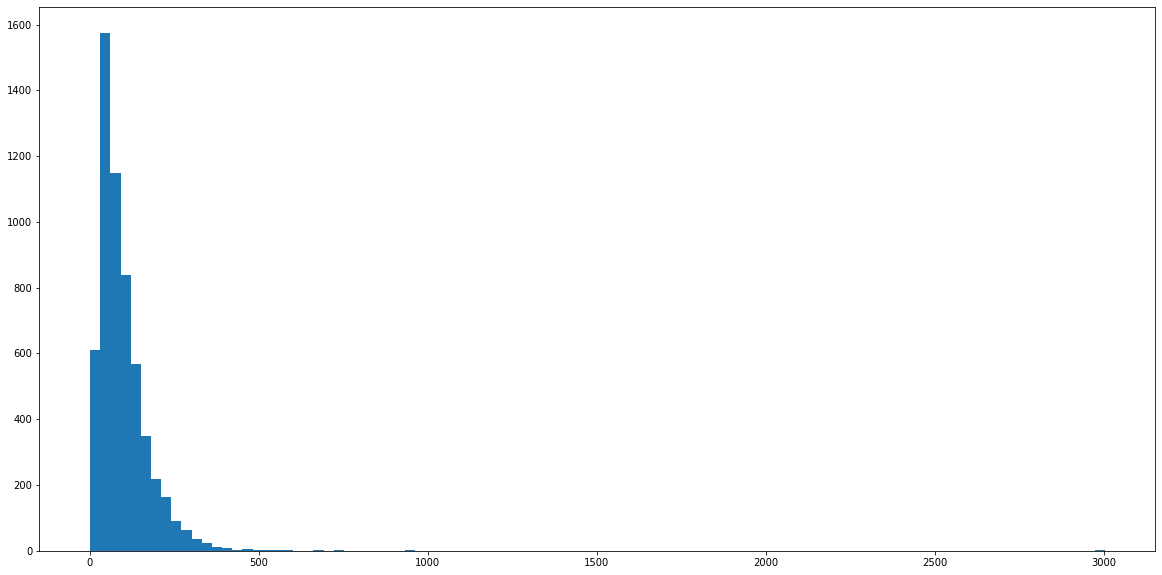

In [ ]:
# View distribution of sentence lengths

_ = plt.hist([len(x) for x in novel_sentences_ls], bins=100)

# **Clean and Slice Strings**

In [ ]:
def clean_str(dirty_str):
  '''
  INPUT: a raw string
  OUTPUT: a clean string
  '''

  contraction_expanded_str = contractions.fix(dirty_str)

  clean_str = clean(contraction_expanded_str,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=False,                  # replace all URLs with a special token
      no_emails=False,                # replace all email addresses with a special token
      no_phone_numbers=False,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=False,                 # remove punctuations
      # replace_with_punct="",          # instead of removing punctuations you may replace them
      # replace_with_url="<URL>",
      # replace_with_email="<EMAIL>",
      # replace_with_phone_number="<PHONE>",
      # replace_with_number="<NUMBER>",
      # replace_with_digit="0",
      # replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
  )

  # Replace all new lines/returns with single whitespace
  clean_str = ' '.join(clean_str.split())
  # clean_str = clean_str.replace('\n\r', ' ')
  # clean_str = clean_str.replace('\n', ' ')
  # clean_str = clean_str.replace('\r', ' ')
  # clean_str = ' '.join(clean_str.split())

  # Strip unpaired leading/trailing quotes
  if (clean_str.count('"') % 2 == 1):
    clean_str = clean_str.strip('"')
  if (clean_str.count("'") % 2 == 1):
    clean_str = clean_str.strip("'")

  return clean_str 

# Test

clean_str("This \n\n\n is a very dirty DIRTY StrInG!!")
clean_str('"up!')
clean_str('"Watch out!" he said.')

'this is a very dirty dirty string!!'

'up!'

'"watch out!" he said.'

In [ ]:
# Verify

# verify_novel(novel_clean_str, index_ends=500)

In [ ]:
# Create sentiment_df to hold text sentences and corresponding sentiment values

sentiment_df = pd.DataFrame({'text_raw': novel_sentences_ls})
sentiment_df['text_raw'] = sentiment_df['text_raw'].astype('string')
sentiment_df['text_raw'] = sentiment_df['text_raw'].str.strip()

sentiment_df.head()
sentiment_df.info()

,text_raw
0,ANNE OF GREEN GABLES By Lucy Maud Montgomer...
1,There are plenty of people in Avonlea and out ...
2,She was a notable housewife; her work was alw...
3,Yet with all this Mrs. Rachel found abundant ...
4,Since Avonlea occupied a little triangular pe...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5723 entries, 0 to 5722
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  5723 non-null   string
dtypes: string(1)
memory usage: 44.8 KB


In [ ]:
# clean the 'text_raw' column and create the 'text_clean' column

# novel_df['text_clean'] = hero.clean(novel_df['text_raw'])
sentiment_df['text_clean'] = sentiment_df['text_raw'].apply(lambda x: clean_str(x))
sentiment_df['text_clean'] = sentiment_df['text_clean'].astype('string')
sentiment_df['text_raw_len'] = sentiment_df['text_raw'].apply(lambda x: len(x))

sentiment_df.head()
sentiment_df.info()

,text_raw,text_clean,text_raw_len
0,ANNE OF GREEN GABLES By Lucy Maud Montgomer...,anne of green gables by lucy maud montgomery t...,3003
1,There are plenty of people in Avonlea and out ...,there are plenty of people in avonlea and out ...,274
2,She was a notable housewife; her work was alw...,she was a notable housewife; her work was alwa...,215
3,Yet with all this Mrs. Rachel found abundant ...,yet with all this mrs. rachel found abundant t...,321
4,Since Avonlea occupied a little triangular pe...,since avonlea occupied a little triangular pen...,263


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5723 entries, 0 to 5722
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_raw      5723 non-null   string
 1   text_clean    5723 non-null   string
 2   text_raw_len  5723 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 134.3 KB


In [ ]:
# Drop Sentence if Raw length < 1 (Double check)

# sentiment_df = sentiment_df[sentiment_df['text_raw_len'] > 0]

print(f"\n\nThere are {sentiment_df['text_raw'].isna().sum()} BLANK [text_raw] lines")

print(f"There are {sentiment_df['text_clean'].isna().sum()} BLANK [text_clean] lines")

sentiment_df.shape



There are 0 BLANK [text_raw] lines
There are 0 BLANK [text_clean] lines


(5723, 3)

In [ ]:
sentiment_df.sort_values(by=['text_raw_len']).head(20)

,text_raw,text_clean,text_raw_len
2616,A.,a.,2
3725,No?,no?,3
2614,P.S.,p.s.,4
3247,“Mr.,mr.,4
769,“Mr.,mr.,4
3494,“Mr.,mr.,4
4048,“No.,no.,4
4323,“No.,no.,4
257,“Mrs.,mrs.,5
3229,“Mrs.,mrs.,5


# **Sentiment Analysis**

## **VADER**

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 17.5 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_sa = SentimentIntensityAnalyzer()

In [ ]:
vader_sa.polarity_scores('I love lint')['compound']

0.6369

In [ ]:
sentiment_df['vader'] = sentiment_df['text_clean'].apply(lambda x : vader_sa.polarity_scores(x)['compound'])
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader
0,ANNE OF GREEN GABLES By Lucy Maud Montgomer...,anne of green gables by lucy maud montgomery t...,3003,-0.2382
1,There are plenty of people in Avonlea and out ...,there are plenty of people in avonlea and out ...,274,0.5789
2,She was a notable housewife; her work was alw...,she was a notable housewife; her work was alwa...,215,0.6124
3,Yet with all this Mrs. Rachel found abundant ...,yet with all this mrs. rachel found abundant t...,321,0.0000
4,Since Avonlea occupied a little triangular pe...,since avonlea occupied a little triangular pen...,263,0.0000
5,She was sitting there one afternoon in early J...,she was sitting there one afternoon in early j...,50,0.0000
6,The sun was coming in at the window warm and ...,the sun was coming in at the window warm and b...,173,0.5859
7,Thomas Lynde--a meek little man whom Avonlea p...,thomas lynde--a meek little man whom avonlea p...,259,0.0000
8,Mrs. Rachel knew that he ought because she ha...,mrs. rachel knew that he ought because she had...,199,0.0000
9,"Peter had asked him, of course, for Matthew C...","peter had asked him, of course, for matthew cu...",134,0.0000


## **TextBlob**

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader,textblob
0,ANNE OF GREEN GABLES By Lucy Maud Montgomer...,anne of green gables by lucy maud montgomery t...,3003,-0.2382,-0.095414
1,There are plenty of people in Avonlea and out ...,there are plenty of people in avonlea and out ...,274,0.5789,0.318750
2,She was a notable housewife; her work was alw...,she was a notable housewife; her work was alwa...,215,0.6124,0.187500
3,Yet with all this Mrs. Rachel found abundant ...,yet with all this mrs. rachel found abundant t...,321,0.0000,0.108333
4,Since Avonlea occupied a little triangular pe...,since avonlea occupied a little triangular pen...,263,0.0000,-0.187500
5,She was sitting there one afternoon in early J...,she was sitting there one afternoon in early j...,50,0.0000,0.100000
6,The sun was coming in at the window warm and ...,the sun was coming in at the window warm and b...,173,0.5859,0.650000
7,Thomas Lynde--a meek little man whom Avonlea p...,thomas lynde--a meek little man whom avonlea p...,259,0.0000,-0.137500
8,Mrs. Rachel knew that he ought because she ha...,mrs. rachel knew that he ought because she had...,199,0.0000,0.000000
9,"Peter had asked him, of course, for Matthew C...","peter had asked him, of course, for matthew cu...",134,0.0000,0.200000


## **DistilBERT**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

In [ ]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
%%time

# Test: text_sentiment_dt['cdickins_achristmascarol']['text_clean']

# NOTE:  1m38s 14:00EST on 01 Nov 2022 Colab Pro (The Great Gatsby)
#        1m39s 17:05EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute sentiment time series

def get_distilbert_sentiment(text_clean_ls, sample_size=10):
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()

  # Tokenize texts and create prediction data set
  tokenized_texts = tokenizer(text_clean_ls,truncation=True,padding=True)
  pred_dataset = SimpleDataset(tokenized_texts)

  # Run predictions
  predictions = trainer.predict(pred_dataset)

  # Transform predictions to labels
  sentiment_ls = predictions.predictions.argmax(-1)
  label_ls = pd.Series(sentiment_ls).map(model.config.id2label)
  score_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

  # Create DataFrame with texts, predictions, labels, and scores
  # line_no_ls = list(range(len(sentiment_ls)))
  # distilbert_df = pd.DataFrame(list(zip(line_no_ls, text_clean_ls,sentiment_ls,label_ls,score_ls)), columns=['line_no','line','sentiment','label','score'])
  # distilbert_df.head()

  # Adjust for POS/NEG sign
  label_score_ls = list(zip(label_ls,score_ls))
  sentiment_signed_ls = [ascore if alabel.lower().strip()=='positive' else (-1.0*ascore) for alabel, ascore in label_score_ls] 

  # print(f'label_ls:\n  {label_ls[:sample_size]}')
  # print(f'score_ls:\n {score_ls[:sample_size]}')

  return sentiment_signed_ls, label_ls

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [ ]:
# Test

line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']
sentiment_signed_ls, label_ls = get_distilbert_sentiment(line_ls)

print(f'sentiment_signed_ls:\n  {sentiment_signed_ls}')
print(f'label_ls:\n  {label_ls}')

***** Running Prediction *****
  Num examples = 4
  Batch size = 8


sentiment_signed_ls:
  [0.9998562, -0.9997524619102478, 0.9998695, 0.9502347]
label_ls:
  0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    POSITIVE
dtype: object


In [ ]:
%%time

# NOTE: ~20m

text_clean_ls = sentiment_df['text_clean'].to_list()
sentiment_ls, label_ls = get_distilbert_sentiment(text_clean_ls)

sentiment_df['distilbert'] = sentiment_ls
sentiment_df.head()
sentiment_df.info()

***** Running Prediction *****
  Num examples = 5723
  Batch size = 8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5723 entries, 0 to 5722
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text_raw      5723 non-null   string 
 1   text_clean    5723 non-null   string 
 2   text_raw_len  5723 non-null   int64  
 3   vader         5723 non-null   float64
 4   textblob      5723 non-null   float64
 5   distilbert    5723 non-null   float64
dtypes: float64(3), int64(1), string(2)
memory usage: 268.4 KB
CPU times: user 1min 32s, sys: 546 ms, total: 1min 32s
Wall time: 1min 34s


In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,distilbert
0,ANNE OF GREEN GABLES By Lucy Maud Montgomer...,anne of green gables by lucy maud montgomery t...,3003,-0.2382,-0.095414,-0.563295
1,There are plenty of people in Avonlea and out ...,there are plenty of people in avonlea and out ...,274,0.5789,0.318750,0.999157
2,She was a notable housewife; her work was alw...,she was a notable housewife; her work was alwa...,215,0.6124,0.187500,0.999698
3,Yet with all this Mrs. Rachel found abundant ...,yet with all this mrs. rachel found abundant t...,321,0.0000,0.108333,0.987455
4,Since Avonlea occupied a little triangular pe...,since avonlea occupied a little triangular pen...,263,0.0000,-0.187500,-0.716206


In [ ]:
%whos str

Variable             Type    Data/Info
--------------------------------------
Novel_Title          str     Anne of Green Gables By Lucy Maud Montgomery 
TEXT_ENCODING        str     utf-8
\nsoftly.
fn                   str     Anne of Green Gables .txt
model_name           str     distilbert-base-uncased-finetuned-sst-2-english
novel_clean_str      str     
novel_filename_str   str     Anne of Green Gables .txt
\n
novel_title_str      str     Anne Of Green Gables By Lucy Maud Montgomery


In [ ]:
slugify(Novel_Title)

'anne-of-green-gables-by-lucy-maud-montgomery'

In [ ]:
"".join(novel_filename_str.split('.')[:-1]).lower()

'anne of green gables '

In [ ]:
filename_sentiment = f"novel_sentiment_{slugify(''.join(novel_filename_str.split('.')[:-1]).lower(), separator='_')}.csv"
sentiment_df.to_csv(filename_sentiment)

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_sentiment}] <<<<<')



     >>>>> SAVED PLOT TO FILE: [novel_sentiment_anne_of_green_gables.csv] <<<<<


In [ ]:
files.download(filename_sentiment)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Plot Sentiment**

In [ ]:
sentiment_df.insert(0, 'SeqNo', list(range(0, sentiment_df.shape[0])))

In [ ]:
sentiment_df.head()

,SeqNo,text_raw,text_clean,text_raw_len,vader,textblob,distilbert
0,0,ANNE OF GREEN GABLES By Lucy Maud Montgomer...,anne of green gables by lucy maud montgomery t...,3003,-0.2382,-0.095414,-0.563295
1,1,There are plenty of people in Avonlea and out ...,there are plenty of people in avonlea and out ...,274,0.5789,0.318750,0.999157
2,2,She was a notable housewife; her work was alw...,she was a notable housewife; her work was alwa...,215,0.6124,0.187500,0.999698
3,3,Yet with all this Mrs. Rachel found abundant ...,yet with all this mrs. rachel found abundant t...,321,0.0000,0.108333,0.987455
4,4,Since Avonlea occupied a little triangular pe...,since avonlea occupied a little triangular pen...,263,0.0000,-0.187500,-0.716206


In [ ]:
from sklearn.preprocessing import StandardScaler

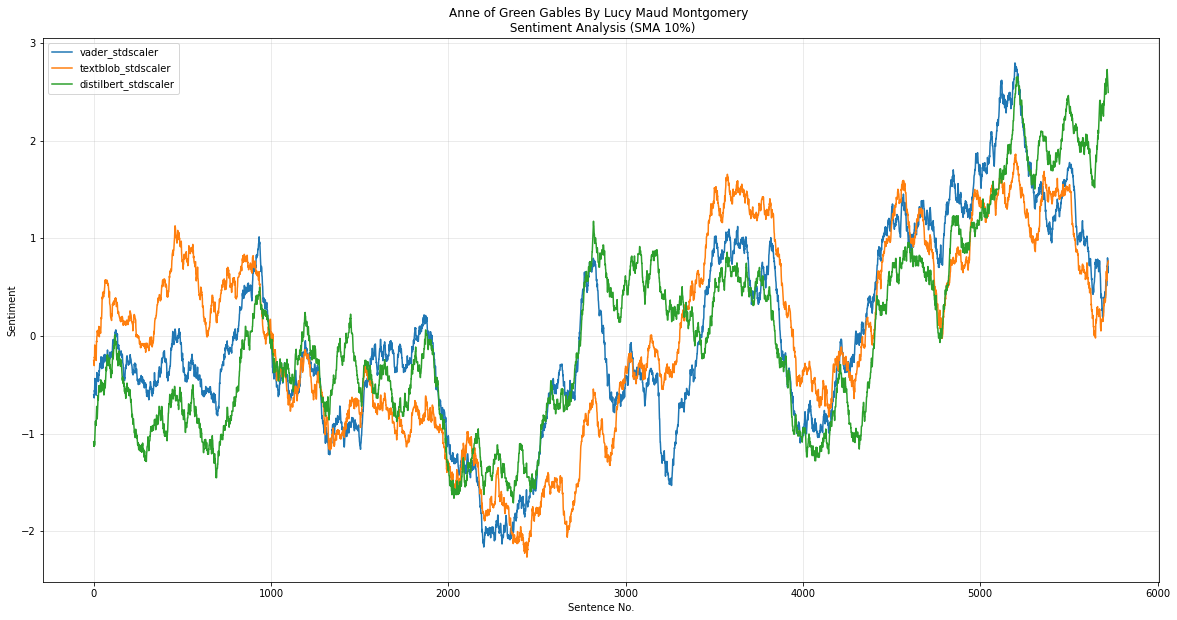

In [ ]:
#@title Enter the Sliding Window width as Percent of Novel length (default 10%, larger=smoother)

plt.rcParams['figure.figsize'] = [20, 10]

window_percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = int(window_percent/100 * sentiment_df.shape[0])

vader_col = f'vader_sma{window_percent}'
sentiment_df[vader_col] = sentiment_df['vader'].rolling(win_per, center=True, min_periods=1).mean()

textblob_col = f'textblob_sma{window_percent}'
sentiment_df[textblob_col] = sentiment_df['textblob'].rolling(win_per, center=True, min_periods=1).mean()

distilbert_col = f'distilbert_sma{window_percent}'
sentiment_df[distilbert_col] = sentiment_df['distilbert'].rolling(win_per, center=True, min_periods=1).mean()

# Normalize Time Series to same y-range
sentiment_model_ls = [vader_col, textblob_col, distilbert_col]
sentiment_model_norm_ls = ['vader_stdscaler',
                           'textblob_stdscaler',
                           'distilbert_stdscaler']

sentiment_df[sentiment_model_norm_ls] = StandardScaler().fit_transform(sentiment_df[sentiment_model_ls])

sentiment_df.plot(y=sentiment_model_norm_ls, x='SeqNo')

plt.title(f'{Novel_Title}\n Sentiment Analysis (SMA {window_percent}%)')
plt.ylabel('Sentiment')
plt.xlabel('Sentence No.')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show();

In [ ]:
sentiment_df.head()

,SeqNo,text_raw,text_clean,text_raw_len,vader,textblob,distilbert,vader_sma10,textblob_sma10,distilbert_sma10,vader_stdscaler,textblob_stdscaler,distilbert_stdscaler
0,0,ANNE OF GREEN GABLES By Lucy Maud Montgomer...,anne of green gables by lucy maud montgomery t...,3003,-0.2382,-0.095414,-0.563295,0.101129,0.066773,-0.083562,-0.601402,-0.250196,-1.081661
1,1,There are plenty of people in Avonlea and out ...,there are plenty of people in avonlea and out ...,274,0.5789,0.318750,0.999157,0.100777,0.066540,-0.086744,-0.612120,-0.259909,-1.125995
2,2,She was a notable housewife; her work was alw...,she was a notable housewife; her work was alwa...,215,0.6124,0.187500,0.999698,0.100427,0.065745,-0.083752,-0.622762,-0.293114,-1.084311
3,3,Yet with all this Mrs. Rachel found abundant ...,yet with all this mrs. rachel found abundant t...,321,0.0000,0.108333,0.987455,0.100080,0.065517,-0.086903,-0.633332,-0.302612,-1.128208
4,4,Since Avonlea occupied a little triangular pe...,since avonlea occupied a little triangular pen...,263,0.0000,-0.187500,-0.716206,0.102587,0.067619,-0.083156,-0.557082,-0.214864,-1.076000


# **Crux Detection**

In [ ]:
#@title Which Lexicon?

Sentiment_Model = "VADER" #@param ["VADER", "TextBlob", "DistilBERT"]

<ipython-input-54-015d760dab2f>:37: PeakPropertyWarning: some peaks have a width of 0
  valleys3, _ = find_peaks(x_inv, width=width_min)


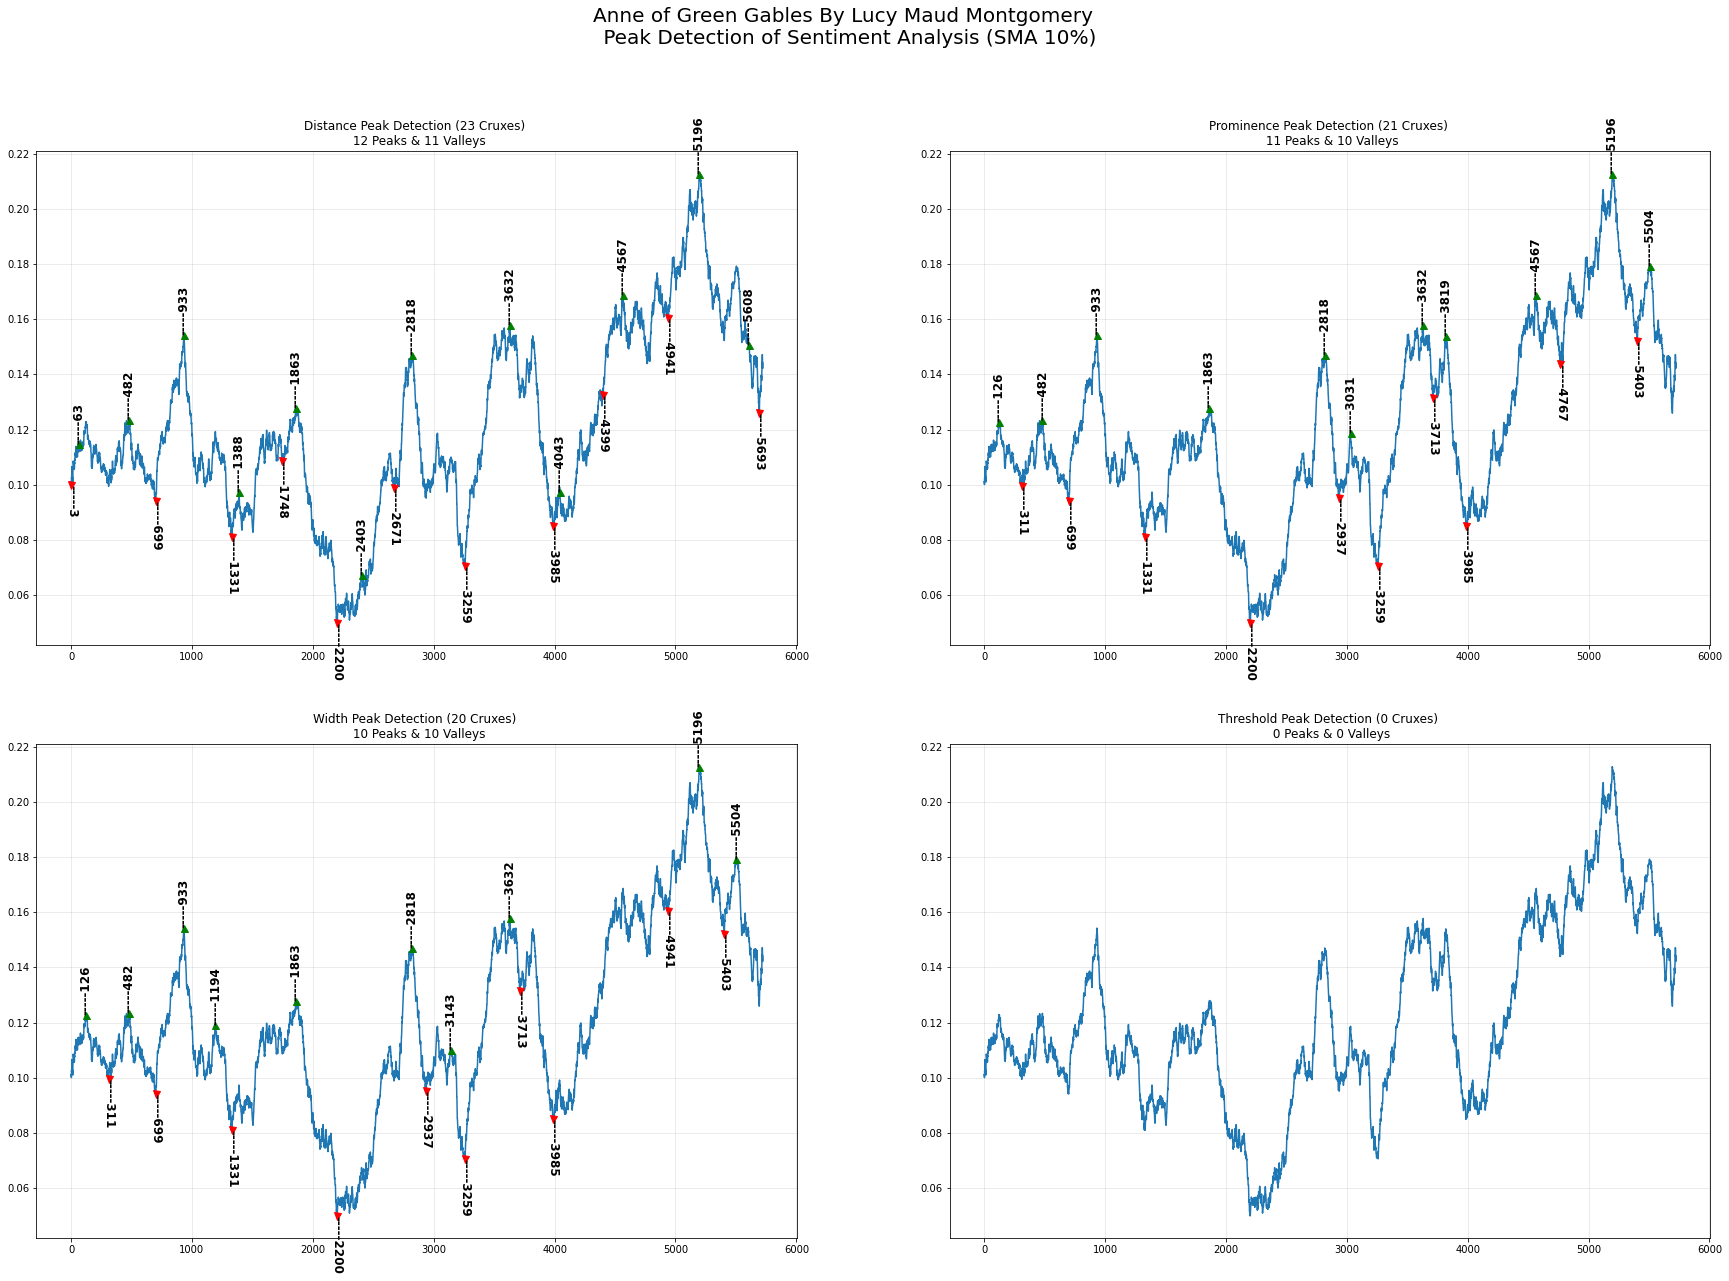

In [ ]:
#@title Tune the main Hyperparameter for each of the 4 Peak Detection Algorithms:

Distance_Min = 410 #@param {type:"slider", min:100, max:1000, step:10}
Prominence_Min = 0.022 #@param {type:"slider", min:0.001, max:0.05, step:0.001}
Width_Min = 60 #@param {type:"slider", min:25, max:500, step:5}
Threshold_Min = 0.005 #@param {type:"slider", min:0.001, max:0.01, step:0.001}

plt.rcParams['figure.figsize'] = [30, 20]

model_name = f'{Sentiment_Model.lower()}_sma{window_percent}'

x = sentiment_df[model_name]

# Peak Algo #1 (by Distance)
distance_min = Distance_Min # 750

# Peak Algo #2 (by Prominence)
prominence_min = Prominence_Min # 0.01

# Peak Algo #3 (by Width)
width_min = Width_Min # 175

# Peak Algo #4 (by Threshold)
threshold_min = Threshold_Min # 0.001


peaks, _ = find_peaks(x, distance=distance_min)
peaks2, _ = find_peaks(x, prominence=prominence_min)      # BEST!
peaks3, _ = find_peaks(x, width=width_min)
peaks4, _ = find_peaks(x, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


x_inv = pd.Series([-x for x in sentiment_df[model_name].to_list()])

valleys, _ = find_peaks(x_inv, distance=distance_min)
valleys2, _ = find_peaks(x_inv, prominence=prominence_min)      # BEST!
valleys3, _ = find_peaks(x_inv, width=width_min)
valleys4, _ = find_peaks(x_inv, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


_ = plt.subplot(2, 2, 1)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Distance Peak Detection ({len(peaks)+len(valleys)} Cruxes) \n {len(peaks)} Peaks & {len(valleys)} Valleys')
_ = plt.plot(peaks, x[peaks], "^g", markersize=7)
_ = plt.plot(valleys, x[valleys], "vr", markersize=7)
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.subplot(2, 2, 2)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Prominence Peak Detection ({len(peaks2)+len(valleys2)} Cruxes) \n {len(peaks2)} Peaks & {len(valleys2)} Valleys')
_ = plt.plot(peaks2, x[peaks2], "^g", markersize=7)
_ = plt.plot(valleys2, x[valleys2], "vr", markersize=7)
for x_val in peaks2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 3)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Width Peak Detection ({len(peaks3)+len(valleys3)} Cruxes) \n {len(peaks3)} Peaks & {len(valleys3)} Valleys')
_ = plt.plot(valleys3, x[valleys3], "vr", markersize=7)
_ = plt.plot(peaks3, x[peaks3], "^g", markersize=7)
for x_val in peaks3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 4)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Threshold Peak Detection ({len(peaks4)+len(valleys4)} Cruxes) \n {len(peaks4)} Peaks & {len(valleys4)} Valleys')
_ = plt.plot(valleys4, x[valleys4], "vr", markersize=7)
_ = plt.plot(valleys4, x[valleys4], "^g", markersize=7)
for x_val in peaks4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.suptitle(f'{Novel_Title}\n Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=20)
_ = plt.grid(True, alpha=0.3)

_ = plt.show()

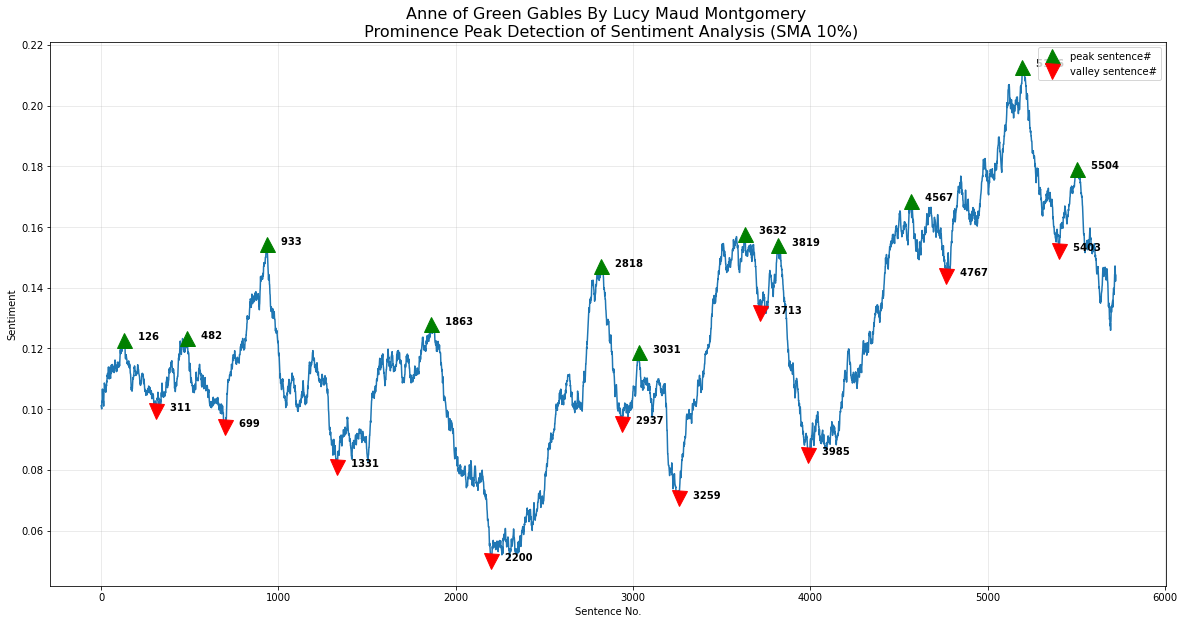



     >>>>> SAVED PLOT TO FILE: [cruxes_plot_Anne_of_Green_Gables_By_Lucy_Maud_Montgomery_.png] <<<<<


In [ ]:
#@title Select a Peak Detection Algorithms to View in Detail (usually Distance or Width is best):

plt.rcParams['figure.figsize'] = [20, 10]

Peak_Algorithm = "Prominence" #@param ["Distance", "Prominence", "Width", "Threshold"]

if Peak_Algorithm == 'Distance':
  peaks = peaks
  valleys = valleys
elif Peak_Algorithm == 'Prominence':
  peaks = peaks2
  valleys = valleys2  
elif Peak_Algorithm == 'Width':
  peaks = peaks3
  valleys = valleys3
else:
  # Assume Peak_Algorithm == 'Threshold'
  peaks = peaks4
  valleys = valleys4

# model_name = f'{Sentiment_Model.lower()}_sma10'

# x = novel_clean_df[model_name]

# peaks2, _ = find_peaks(x, prominence=peak_prominence)  

# x_inv = pd.Series([-x for x in novel_clean_df[model_name].to_list()])
# valleys2, _ = find_peaks(x_inv, prominence=peak_prominence)     

_ = plt.plot(x)
_ = plt.plot(peaks, x[peaks], "^g", markersize=15, label='peak sentence#')
_ = plt.plot(valleys, x[valleys], "vr", markersize=15, label='valley sentence#')
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
_ = plt.title(f'{Novel_Title}\n {Peak_Algorithm} Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=16)
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.legend(loc='best')
_ = plt.grid(True, alpha=0.3)

filename_plot = f"cruxes_plot_{Novel_Title.replace(' ', '_')}.png"
_ = plt.savefig(filename_plot, dpi=300)
_ = plt.show();

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_plot}] <<<<<')

In [ ]:
# Download Crux Point Plot file 'crux_plot.png' to your laptop

files.download(filename_plot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Get Context around Crux Points**

In [ ]:
#@title How many Sentences around Crux Point do you want to view for context?

Crux_Sentence_Context_Count = 19 #@param {type:"slider", min:1, max:20, step:1}


In [ ]:
# Print Context around each Sentiment Peak

output_ls = []

halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('============     Peak Crux Points   ==============')
output_ls.append('==================================================\n\n')

# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  print(f'Processing Peak #{i}...')
  crux_sents_ls = []
  for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = sentiment_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('===========     Crux Valley Points    ============')
output_ls.append('==================================================\n\n')

# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  print(f'Processing Valley #{i}')
  crux_sents_ls = []
  for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

filename_cruxes = f"cruxes_context_{Novel_Title.replace(' ', '_')}.txt" 

output_str = ' '.join(output_ls)

with open(filename_cruxes, 'w') as f:
    f.write(output_str)

============     Peak Crux Points   ==============


Processing Peak #0...
Peak #0 at Sentence #126:

“Well, of all things that ever were or will be!” ejaculated Mrs. Rachel
when she was safely out in the lane.
“It does really seem as if I must
be dreaming.
Well, I’m sorry for that poor young one and no mistake.
Matthew and Marilla don’t know anything about children and they’ll
expect him to be wiser and steadier that his own grandfather, if so be’s
he ever had a grandfather, which is doubtful.
It seems uncanny to think
of a child at Green Gables somehow; there’s never been one there, for
Matthew and Marilla were grown up when the new house was built--if they
ever _were_ children, which is hard to believe when one looks at them.
I wouldn’t be in that orphan’s shoes for anything.
My, but I pity him,
that’s what.”

So said Mrs. Rachel to the wild rose bushes out of the fulness of her
heart; but if she could have seen the child who was waiting patiently
at the Bright River station at that

42235

In [ ]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

files.download(filename_cruxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cat $filename_cruxes

================================================== ============     Peak Crux Points   ============== ==================================================

 Peak #0 at Sentence #126:

“Well, of all things that ever were or will be!” ejaculated Mrs. Rachel
when she was safely out in the lane.
“It does really seem as if I must
be dreaming.
Well, I’m sorry for that poor young one and no mistake.
Matthew and Marilla don’t know anything about children and they’ll
expect him to be wiser and steadier that his own grandfather, if so be’s
he ever had a grandfather, which is doubtful.
It seems uncanny to think
of a child at Green Gables somehow; there’s never been one there, for
Matthew and Marilla were grown up when the new house was built--if they
ever _were_ children, which is hard to believe when one looks at them.
I wouldn’t be in that orphan’s shoes for anything.
My, but I pity him,
that’s what.”

So said Mrs. Rachel to the wild rose bushes out of the fulness of her
heart; but if she could h

# **END OF NOTEBOOK**